Loading: testwav/uudb_full.wav, Sampling Rate: 22050Hz


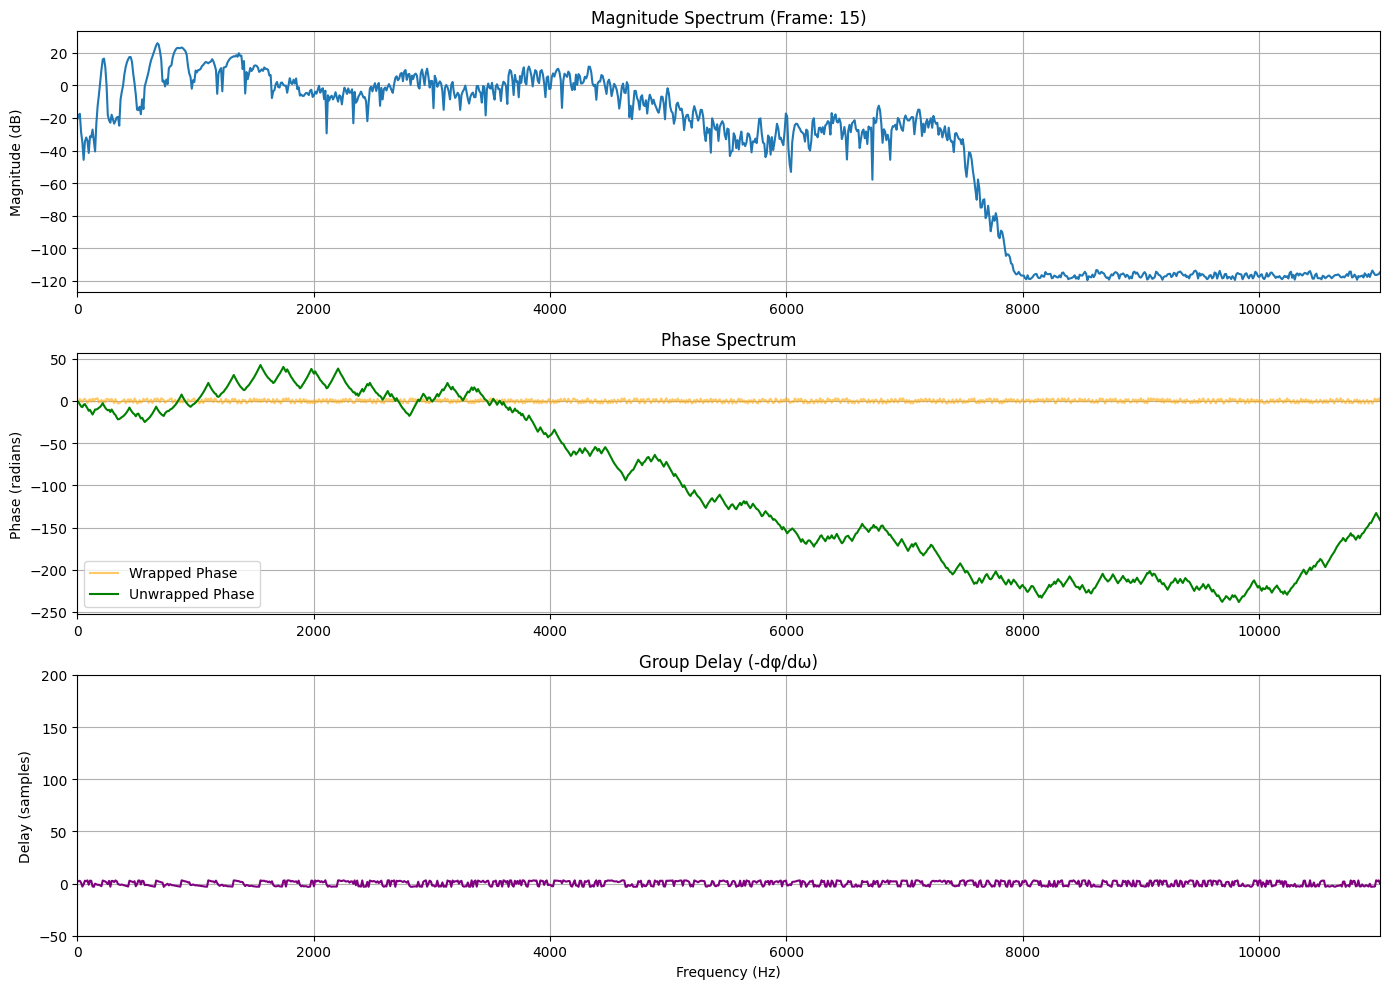

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


def analyze_phase_spectrum(filename=None):
    # 1. 音声の読み込み (ファイル指定がない場合はlibrosaのサンプルを使用)
    if filename:
        y, sr = librosa.load(filename)
    else:
        # トランペットのサンプル音源を使用
        filename = librosa.ex('trumpet')
        y, sr = librosa.load(filename)
    
    print(f"Loading: {filename}, Sampling Rate: {sr}Hz")

    # 2. 短時間フーリエ変換 (STFT)
    # n_fft: FFTの点数, hop_length: フレームの移動幅
    n_fft = 2048
    hop_length = 512
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # 3. 分析するフレームの選択
    # 音量が最大のフレーム（音がはっきりしている部分）を自動選択します
    magnitude = np.abs(D)
    target_frame_idx = np.argmax(np.sum(magnitude, axis=0))
    
    # 対象フレームのスペクトルを抽出
    spectrum = D[:, target_frame_idx]
    
    # 周波数軸の作成
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # --- 位相情報の計算 ---
    
    # A. 位相スペクトル (Wrapped Phase): -pi ~ +pi
    phase_wrapped = np.angle(spectrum)

    # B. アンラップ位相 (Unwrapped Phase): 連続的な位相変化
    #    2piの跳躍を補正して滑らかにつなぐ
    phase_unwrapped = np.unwrap(phase_wrapped)

    # C. 群遅延 (Group Delay): 位相の周波数微分（負の勾配）
    #    共振（フォルマント）部分でピークが立つため、音声の特徴分析に役立ちます
    group_delay = -np.diff(phase_unwrapped)
    # diffで要素数が1つ減るため、プロット用に調整
    group_delay = np.append(group_delay, 0) 


    # --- プロット ---
    plt.figure(figsize=(14, 10))

    # 1. 振幅スペクトル (参考用)
    plt.subplot(3, 1, 1)
    plt.plot(freqs, 20 * np.log10(np.abs(spectrum) + 1e-6))
    plt.title(f'Magnitude Spectrum (Frame: {target_frame_idx})')
    plt.ylabel('Magnitude (dB)')
    plt.xlim(0, sr/2)
    plt.grid(True)

    # 2. 位相スペクトル (Wrapped & Unwrapped)
    plt.subplot(3, 1, 2)
    plt.plot(freqs, phase_wrapped, label='Wrapped Phase', color='orange', alpha=0.6)
    plt.plot(freqs, phase_unwrapped, label='Unwrapped Phase', color='green')
    plt.title('Phase Spectrum')
    plt.ylabel('Phase (radians)')
    plt.legend()
    plt.xlim(0, sr/2)
    plt.grid(True)

    # 3. 群遅延 (Group Delay)
    plt.subplot(3, 1, 3)
    plt.plot(freqs, group_delay, color='purple')
    plt.title('Group Delay (-dφ/dω)')
    plt.ylabel('Delay (samples)')
    plt.xlabel('Frequency (Hz)')
    plt.xlim(0, sr/2)
    # 見やすくするためにY軸を制限（スパイクを除外）
    plt.ylim(-50, 200) 
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 実行
    analyze_phase_spectrum("testwav/uudb_full.wav")

Loading: testwav/uudb_5f.wav, Sampling Rate: 22050Hz


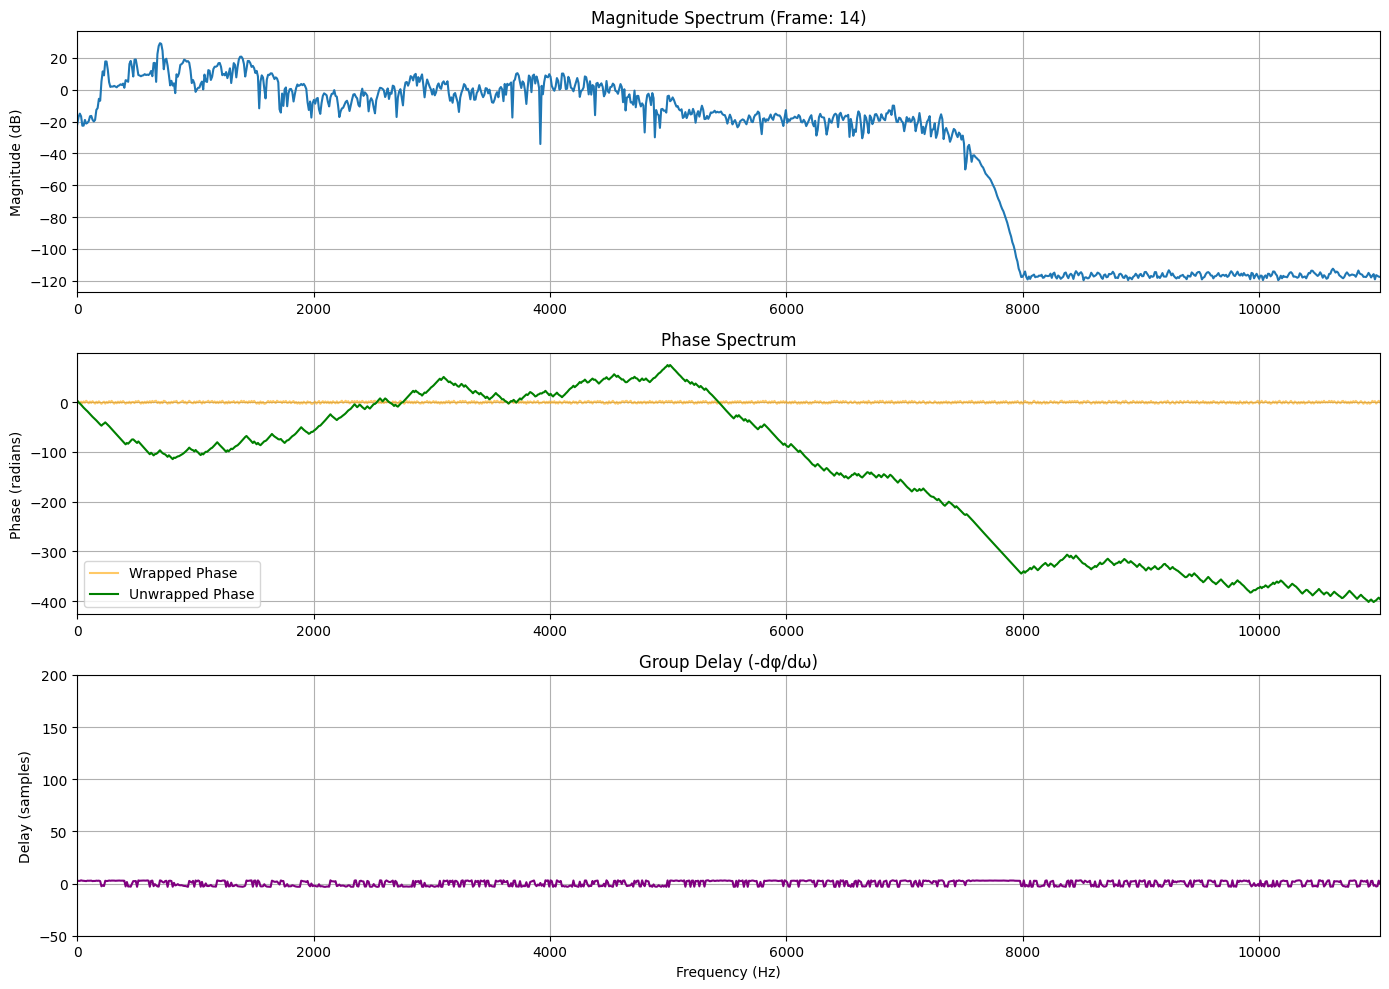

In [5]:
analyze_phase_spectrum("testwav/uudb_5f.wav")

Loading: testwav/uudb_overlap.wav, Sampling Rate: 22050Hz


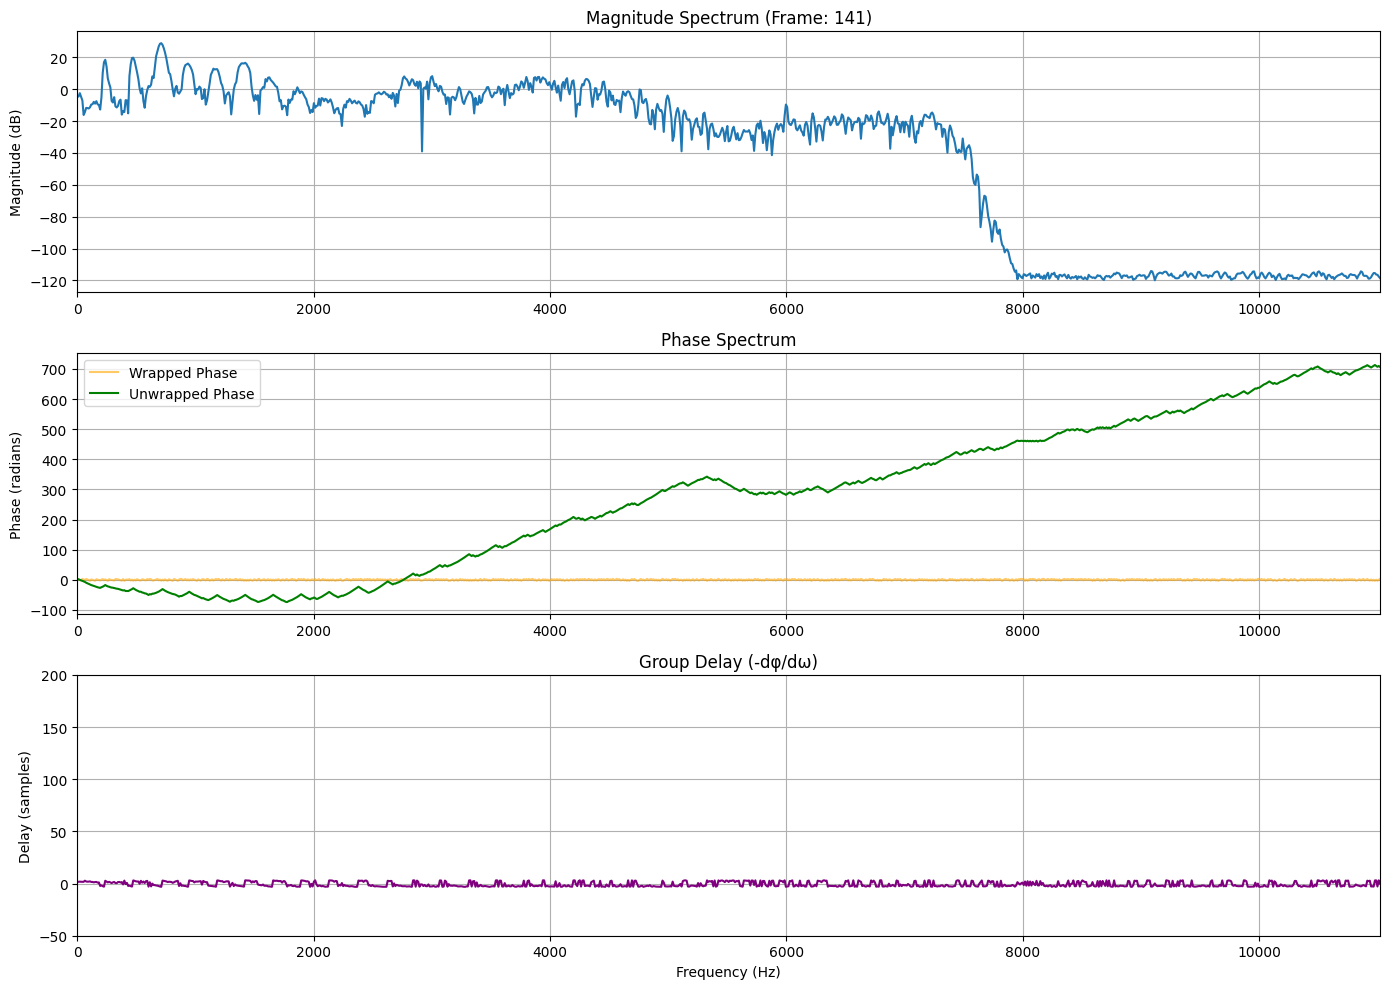

In [6]:
analyze_phase_spectrum("testwav/uudb_overlap.wav")

Loading files...
 - testwav/uudb_full.wav: 24000Hz, 24000 samples
 - testwav/uudb_5f.wav: 24000Hz, 24000 samples
 - testwav/uudb_overlap.wav: 24000Hz, 24000 samples
Analyzing Frame Index: 46 (Based on full)


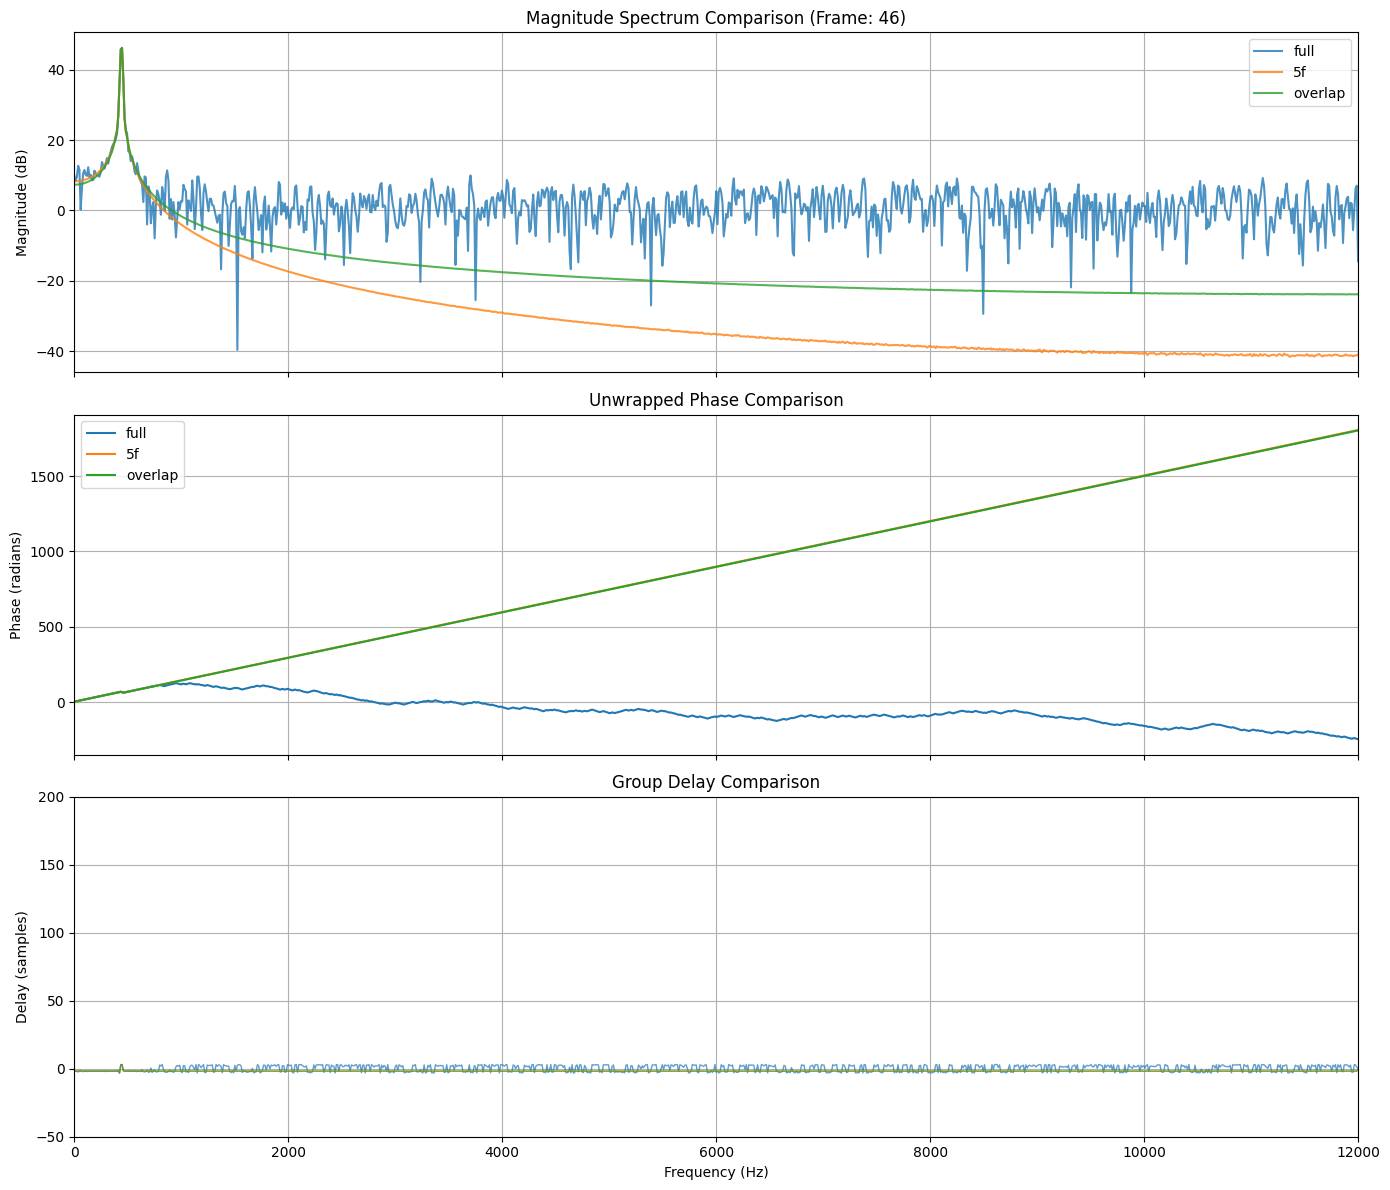

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

def compare_three_phases(file_paths, labels=None):
    """
    3つの音声ファイルの位相スペクトルを同一フレームで比較表示する
    
    Args:
        file_paths (list): 比較したい3つのwavファイルのパスリスト
        labels (list): グラフの凡例用ラベル（['Natural', 'VITS', 'WORLD']など）
    """
    
    if labels is None:
        labels = [f"File {i+1}" for i in range(len(file_paths))]

    # データの格納用
    signals = []
    srs = []
    
    # 1. 音声の読み込み
    print("Loading files...")
    for fp in file_paths:
        y, sr = librosa.load(fp, sr=None) # sr=Noneで元のレートを維持
        signals.append(y)
        srs.append(sr)
        print(f" - {fp}: {sr}Hz, {len(y)} samples")

    # サンプリングレートの一致確認
    if len(set(srs)) > 1:
        print("Warning: Sampling rates differ. Using the first file's SR for plotting.")
    sr = srs[0]

    # 長さの不一致を防ぐため、最短の長さに合わせる
    min_len = min([len(y) for y in signals])
    signals = [y[:min_len] for y in signals]

    # 2. STFT設定
    n_fft = 2048
    hop_length = 512
    
    # 全ファイルのスペクトルを計算
    spectrums = []
    for y in signals:
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        spectrums.append(D)

    # 3. 分析フレームの決定（1つ目のファイルを基準にする）
    # 1つ目のファイル（通常は自然音声）の音量が最大のフレームを探す
    magnitude_ref = np.abs(spectrums[0])
    target_frame_idx = np.argmax(np.sum(magnitude_ref, axis=0))
    print(f"Analyzing Frame Index: {target_frame_idx} (Based on {labels[0]})")

    # 周波数軸
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    # プロット準備
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # 青, オレンジ, 緑

    # ループ処理で3つのデータをプロット
    for i, D in enumerate(spectrums):
        # 該当フレームの抽出
        spec_frame = D[:, target_frame_idx]
        
        # --- 計算 ---
        mag = 20 * np.log10(np.abs(spec_frame) + 1e-6)
        
        phase_wrapped = np.angle(spec_frame)
        phase_unwrapped = np.unwrap(phase_wrapped)
        
        # 群遅延 (-dφ/dω)
        group_delay = -np.diff(phase_unwrapped)
        group_delay = np.append(group_delay, 0) # 次元合わせ

        # --- プロット 1: 振幅スペクトル ---
        axes[0].plot(freqs, mag, label=labels[i], color=colors[i], alpha=0.8, linewidth=1.5)
        
        # --- プロット 2: アンラップ位相 ---
        # 比較しやすいようにDC成分(0Hz)を0に合わせてオフセット調整する場合
        # phase_unwrapped -= phase_unwrapped[0] 
        axes[1].plot(freqs, phase_unwrapped, label=labels[i], color=colors[i], linewidth=1.5)

        # --- プロット 3: 群遅延 ---
        # スパイクが見やすいように少し透明度を入れる
        axes[2].plot(freqs, group_delay, label=labels[i], color=colors[i], alpha=0.7, linewidth=1)

    # --- グラフの装飾 ---
    axes[0].set_title(f'Magnitude Spectrum Comparison (Frame: {target_frame_idx})')
    axes[0].set_ylabel('Magnitude (dB)')
    axes[0].legend(loc='upper right')
    axes[0].grid(True)
    
    axes[1].set_title('Unwrapped Phase Comparison')
    axes[1].set_ylabel('Phase (radians)')
    axes[1].legend(loc='upper left')
    axes[1].grid(True)

    axes[2].set_title('Group Delay Comparison')
    axes[2].set_ylabel('Delay (samples)')
    axes[2].set_xlabel('Frequency (Hz)')
    axes[2].set_ylim(-50, 200) # スパイクが大きすぎる場合に見やすく制限
    axes[2].grid(True)
    
    # 表示範囲をナイキスト周波数までに制限
    plt.xlim(0, sr/2)
    plt.tight_layout()
    plt.show()

# --- 実行部分 ---
if __name__ == "__main__":
    # ここに比較したい3つのファイルパスを入れてください
    # 例: files = ["natural.wav", "vits_base.wav", "vits_proposed.wav"]
    
    # ダミーデータ生成（テスト用：実際はコメントアウトしてファイルパスを指定してください）
    # -----------------------------------------------------------
    sr = 24000
    t = np.linspace(0, 1, sr)
    # 1. 自然音声風（ランダム位相）
    y1 = 0.5 * np.sin(2 * np.pi * 440 * t) + 0.05 * np.random.randn(len(t))
    # 2. 合成音声風A（位相が揃っている）
    y2 = 0.5 * np.sin(2 * np.pi * 440 * t) 
    # 3. 合成音声風B（少し遅れている）
    y3 = 0.5 * np.sin(2 * np.pi * 440 * t - 0.5) 
    
    import soundfile as sf
    sf.write('test_natural.wav', y1, sr)
    sf.write('test_synth_A.wav', y2, sr)
    sf.write('test_synth_B.wav', y3, sr)
    
    files = ['testwav/uudb_full.wav', 'testwav/uudb_5f.wav', 'testwav/uudb_overlap.wav']
    
    labels = ['full', '5f', 'overlap']
    # -----------------------------------------------------------

    compare_three_phases(files, labels)

Tracking Frequency: 445.31 Hz (Bin index: 38)


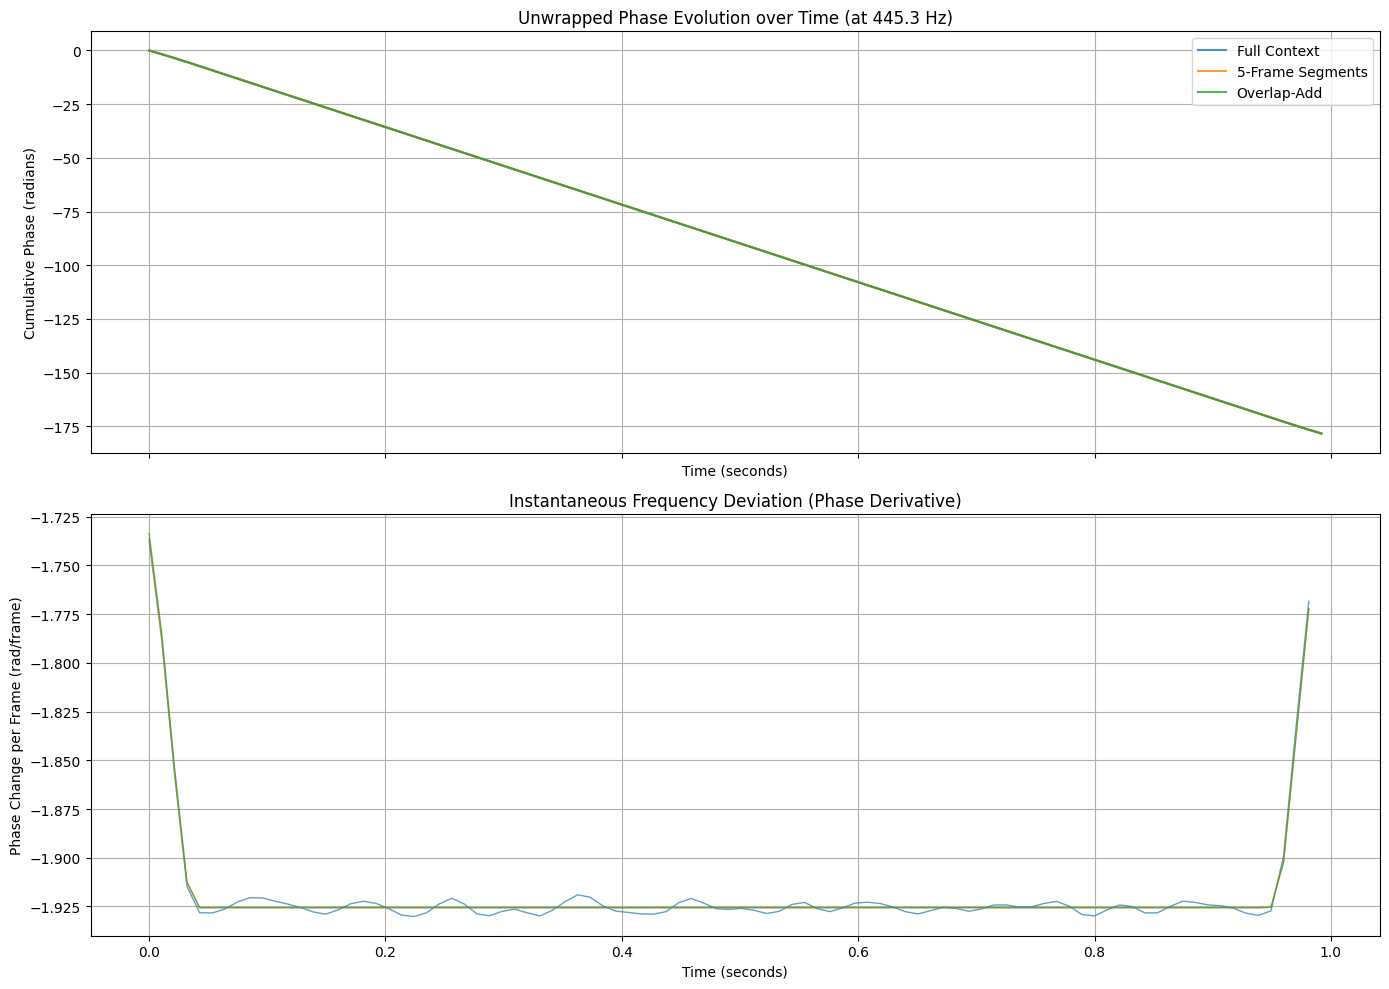

Please set your file paths in the 'files' list and run.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

def analyze_phase_over_time(file_paths, labels=None):
    """
    特定の周波数ビンの位相変化を時系列で追跡・比較する
    """
    if labels is None:
        labels = [f"File {i+1}" for i in range(len(file_paths))]

    # 共通設定
    n_fft = 2048
    hop_length = 256  # 時間分解能を高めるため少し小さめに設定
    
    # データを格納するリスト
    phases_unwrapped = []
    phases_wrapped = []
    magnitudes = []
    
    # 1. 基準となる周波数ビンを決めるために、まず1つ目のファイルを解析
    #    (すべてのファイルで同じ周波数ビンを見ないと比較にならないため)
    y_ref, sr = librosa.load(file_paths[0], sr=None)
    D_ref = librosa.stft(y_ref, n_fft=n_fft, hop_length=hop_length)
    mag_ref = np.abs(D_ref)
    
    # 全時間を通じて最もエネルギーの総和が大きい周波数ビン(index)を特定
    # これが「メインの音（基本周波数や主要な倍音）」である可能性が高い
    target_freq_idx = np.argmax(np.sum(mag_ref, axis=1))
    target_freq_hz = librosa.fft_frequencies(sr=sr, n_fft=n_fft)[target_freq_idx]
    
    print(f"Tracking Frequency: {target_freq_hz:.2f} Hz (Bin index: {target_freq_idx})")

    # 2. 各ファイルの位相を抽出
    min_frames = float('inf')
    
    for fp in file_paths:
        y, _ = librosa.load(fp, sr=sr)
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        
        # 長さを揃えるための準備
        if D.shape[1] < min_frames:
            min_frames = D.shape[1]

        # 特定した周波数ビンの複素数を抽出
        trace = D[target_freq_idx, :]
        
        # 位相計算
        p_wrapped = np.angle(trace)
        p_unwrapped = np.unwrap(p_wrapped)
        
        phases_wrapped.append(p_wrapped)
        phases_unwrapped.append(p_unwrapped)
        magnitudes.append(np.abs(trace))

    # フレーム数を最短のものに合わせる
    phases_wrapped = [p[:min_frames] for p in phases_wrapped]
    phases_unwrapped = [p[:min_frames] for p in phases_unwrapped]
    
    # 時間軸の作成
    times = librosa.frames_to_time(np.arange(min_frames), sr=sr, hop_length=hop_length)

    # --- プロット ---
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # 青, オレンジ, 緑

    # 1. アンラップ位相の時系列変化
    #    直線の傾き = 周波数。
    #    「カクッ」と折れている場所や、線がズレていく様子が「位相リセット」の証拠です。
    axes[0].set_title(f'Unwrapped Phase Evolution over Time (at {target_freq_hz:.1f} Hz)')
    for i, p in enumerate(phases_unwrapped):
        # 比較しやすいように開始地点を0に揃える（オフセット除去）
        p_normalized = p - p[0]
        axes[0].plot(times, p_normalized, label=labels[i], color=colors[i], linewidth=1.5, alpha=0.8)
    
    axes[0].set_ylabel('Cumulative Phase (radians)')
    axes[0].set_xlabel('Time (seconds)')
    axes[0].legend()
    axes[0].grid(True)

    # 2. "瞬時周波数のズレ" (位相の微分)
    #    位相の傾きが急変する場所（つなぎ目）がスパイクとして現れます。
    axes[1].set_title('Instantaneous Frequency Deviation (Phase Derivative)')
    for i, p in enumerate(phases_unwrapped):
        # diffを取ることで「周波数の揺らぎ」が見えます
        # 理想的な持続音なら一定の値（水平）になるはずです
        freq_deviation = np.diff(p) 
        # 時間軸調整
        t_diff = times[:-1]
        axes[1].plot(t_diff, freq_deviation, label=labels[i], color=colors[i], linewidth=1, alpha=0.7)

    axes[1].set_ylabel('Phase Change per Frame (rad/frame)')
    axes[1].set_xlabel('Time (seconds)')
    # axes[1].set_ylim(0, 3) # 必要に応じてY軸を見やすく制限してください
    axes[1].grid(True)

    plt.tight_layout()
    pdf_filename_2 = 'Phase Change per Frame.pdf'
    plt.savefig(pdf_filename_2, format='pdf', bbox_inches='tight')
    plt.show()

# --- 実行 ---
if __name__ == "__main__":
    # ファイルパスを指定してください
    files = ["testwav/uudb_full.wav", "testwav/uudb_5f.wav", "testwav/uudb_overlap.wav"]
    #files = ["full.wav", "5frames.wav", "overlap.wav"]
    labels = ["Full Context", "5-Frame Segments", "Overlap-Add"]
    
    # テスト用ダミーデータ（実際はファイルを指定すれば動きます）
    analyze_phase_over_time(files, labels) 
    print("Please set your file paths in the 'files' list and run.")

NameError: name 'y_original' is not defined